# Getting started with VisionTransformer from PyTorch
In this notebook, you can load a pretrained model and fine-tune it on the desired task.

In [16]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "5"
os.environ['SCIPY_USE_PROPACK'] = "True"
 
threads = "64"
os.environ["OMP_NUM_THREADS"] = threads
os.environ["OPENBLAS_NUM_THREADS"] = threads
os.environ["MKL_NUM_THREADS"] = threads
os.environ["VECLIB_MAXIMUM_THREADS"] = threads
os.environ["NUMEXPR_NUM_THREADS"] = threads

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import DataLoader, random_split


import torchvision
from torchvision import transforms
from torchvision.datasets import CIFAR10, CIFAR100
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter

In [3]:
 # torchvision.models.vision_transformer.VisionTransformer

In [4]:
import matplotlib.pyplot as plt
import numpy as np

In [5]:
# not mandatory
import io
from PIL import Image
from tqdm import tqdm

## Load data

Define transforms and load datasets

In [5]:
data_dir = '/srv/newpenny/dataset'

In [6]:
def get_dataset_config(dataset):
    dataset_config = {
        'CIFAR10': {'num_classes': 10, 
                    'input_ch': 3, 
                    'means': (0.424, 0.415, 0.384), 
                    'stds': (0.283, 0.278, 0.284)},
        
        'CIFAR100': {'num_classes': 100, 
                     'input_ch': 3, 
                     'means': (0.438, 0.418, 0.377), 
                     'stds': (0.300, 0.287, 0.294)},
        
        'ImageNet': {'num_classes': 1000, 
                     'input_ch': 3,
                     'means': [0.485, 0.456, 0.406],
                     'stds': [0.229, 0.224, 0.225]}
    }
    return dataset_config

In [8]:
# def load_data(**kwargs):
def load_data(dataset, split, augment=False, shuffle_train=False, batch_size=64, num_workers=8, seed=42, data_dir='/srv/newpenny/dataset'):
    '''
    dataset (str): choices=['CIFAR10', CIFAR100', 'ImageNet']
    '''
    dc = get_dataset_config(dataset)

    means_ = dc[dataset]['means']
    stds_ = dc[dataset]['stds']
   
    if augment and split=='train': # acts only on the training set
        transform = transforms.Compose([
            #transforms.Grayscale(num_output_channels=3),
            transforms.Resize((256, 256)),
            transforms.AutoAugment(policy=transforms.AutoAugmentPolicy.CIFAR10),
            transforms.CenterCrop((224, 224)),
            #transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(means_, stds_)
        ])
    else:
        transform = transforms.Compose([
            #transforms.Grayscale(num_output_channels=3),
            transforms.Resize((256, 256)),
            transforms.CenterCrop((224, 224)),
            #transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(means_, stds_)
        ])
          
    if dataset=='ImageNet':
        # NB. the loader doesn't work for the 'test' split
        data_path = os.path.join(data_dir, 'imagenet-1k/data')
        data = torchvision.datasets.__dict__[dataset](root=data_path, 
                                                      split=split, 
                                                      transform=transform)
    elif dataset.startswith('CIFAR'):
        data_path = os.path.join(data_dir, dataset)
        if split!='test': # data for train and val
            data = torchvision.datasets.__dict__[dataset](root=data_path, 
                                                        train=True, 
                                                        transform=transform, 
                                                        download=True)
        else:
            data = torchvision.datasets.__dict__[dataset](root=data_path, 
                                                        train=False, 
                                                        transform=transform, 
                                                        download=True)

    if split=='test':
        loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    else:
        # split the dataset into train and validation sets
        train_size = int(0.8 * len(data))
        val_size = len(data) - train_size
        generator = torch.Generator().manual_seed(42)
        train_data, val_data = random_split(data, [train_size, val_size], generator=generator)
        if split=='train':
            loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=shuffle_train, num_workers=num_workers)
        else:
            loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return loader

In [9]:
dataset = 'CIFAR100'
train_loader = load_data(dataset, "train", augment=True)
val_loader = load_data(dataset, "val")

Files already downloaded and verified
Files already downloaded and verified


In [10]:
num_classes = len(train_loader.dataset.dataset.classes)
num_classes

100

## Load Model

Load the pretrained model

In [11]:
model_name = 'vit_b_16' #'resnet50', 'vgg16'

In [12]:
if model_name == 'resnet50':
    weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V1
elif model_name == 'vgg16':
    weights=torchvision.models.VGG16_Weights.IMAGENET1K_V1
elif model_name == 'vit_b_16':
    weights=torchvision.models.ViT_B_16_Weights.IMAGENET1K_V1

model = torchvision.models.__dict__[model_name](weights=weights)

Check the architecture of the model

In [13]:
model

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

Model parameters are saved in a `state_dict`

In [13]:
# model.state_dict()

You can access the keys of the `state_dict` to get the names of layers with parameters (this can be useful to identify layer names and allow for customization)

In [14]:
model.state_dict().keys()

odict_keys(['class_token', 'conv_proj.weight', 'conv_proj.bias', 'encoder.pos_embedding', 'encoder.layers.encoder_layer_0.ln_1.weight', 'encoder.layers.encoder_layer_0.ln_1.bias', 'encoder.layers.encoder_layer_0.self_attention.in_proj_weight', 'encoder.layers.encoder_layer_0.self_attention.in_proj_bias', 'encoder.layers.encoder_layer_0.self_attention.out_proj.weight', 'encoder.layers.encoder_layer_0.self_attention.out_proj.bias', 'encoder.layers.encoder_layer_0.ln_2.weight', 'encoder.layers.encoder_layer_0.ln_2.bias', 'encoder.layers.encoder_layer_0.mlp.0.weight', 'encoder.layers.encoder_layer_0.mlp.0.bias', 'encoder.layers.encoder_layer_0.mlp.3.weight', 'encoder.layers.encoder_layer_0.mlp.3.bias', 'encoder.layers.encoder_layer_1.ln_1.weight', 'encoder.layers.encoder_layer_1.ln_1.bias', 'encoder.layers.encoder_layer_1.self_attention.in_proj_weight', 'encoder.layers.encoder_layer_1.self_attention.in_proj_bias', 'encoder.layers.encoder_layer_1.self_attention.out_proj.weight', 'encoder.la

Change shape of last layer if needed

In [15]:
n_classes = len(train_loader.dataset.dataset.classes)

if model_name == 'resnet50':
    in_features = model.fc.in_features
    model.fc = torch.nn.Linear(in_features, n_classes)
elif model_name == 'vgg16':
    in_features = model.classifier[-1].in_features
    model.classifier[-1] = torch.nn.Linear(in_features, n_classes)
elif model_name == 'vit_b_16':
    in_features = model.heads.head.in_features
    model.heads.head = torch.nn.Linear(in_features, n_classes)

In [16]:
model

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

Now the features in output are 100 -> `out_features=100`

## Training with early stopping and learning rate scheduling
The choice of the parameters reported below strongly affects the quality of the training process. Decomment to try different settings. You will need to find a proper combination to obtain a model performing with desirable properties &#128522;

### Parameter settings

Number of epochs choice

In [23]:
#num_epochs = 100
num_epochs = 15

Loss function and optimizer initialization

In [24]:
criterion = nn.CrossEntropyLoss()

In [25]:
initial_lr = 0.001
optimizer = optim.SGD(model.parameters(), lr=initial_lr, momentum=0.9)
#optimizer = optim.Adam(model.parameters(), lr=initial_lr, weight_decay=1e-4) # more computationally intensive

Early stopping parameters

In [26]:
early_stopping_patience = 10

Learning rate scheduling\
Notes on usage:
* Schedulers like `StepLR`: Decay the learning rate at regular intervals, regardless of validation performance. They are simpler and can be effective for general tasks.
* `ReduceLROnPlateau`: Adapts the learning rate based on validation loss, which can be especially useful in fine-tuning tasks.

In [27]:
#scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

#scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)

lr_patience = 5
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=lr_patience)

You can choose the performance metric you want to optimize during training (typically, accuracy)

In [28]:
def accuracy(outputs, targets):
    _, predicted = torch.max(outputs, 1)  # get the class index with the highest probability
    correct = (predicted == targets).sum().item()
    total = targets.size(0)
    return correct / total

GPU selection

In [29]:
use_cuda = torch.cuda.is_available()
cuda_index = torch.cuda.device_count() - 1
device = torch.device(f"cuda:{cuda_index}" if use_cuda else "cpu")
print(f"Using {device} device")

Using cuda:0 device


In [30]:
model.to(device)

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

Use TensorBoard

In [31]:
save_path = os.path.join(os.path.expanduser("~"), "Documents", "runs")
writer = SummaryWriter(save_path)

In [32]:
save_path

'/home/saravorabbi/Documents/runs'

### Training loop

In [ ]:
patience_counter = 0
best_val_loss = float('inf')

tl = []
vl = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    
    for data in tqdm(train_loader):
        inputs, targets = data
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()        
        
        correct_predictions += accuracy(outputs, targets) * targets.size(0)
        total_predictions += targets.size(0)

    # compute validation loss
    model.eval()
    val_loss = 0.0
    val_correct_predictions = 0
    val_total_predictions = 0
    
    with torch.no_grad():
        for data in val_loader:
            inputs, targets = data
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            
            val_correct_predictions += accuracy(outputs, targets) * targets.size(0)
            val_total_predictions += targets.size(0)
            
    train_loss /= len(train_loader)
    val_loss /= len(val_loader)

    tl.append(train_loss)
    vl.append(val_loss)
    
    train_accuracy = (correct_predictions / total_predictions) * 100
    val_accuracy = (val_correct_predictions / val_total_predictions) * 100
    
	#tensorboard
    writer.add_scalar('train loss',train_loss,epoch)
    writer.add_scalar('train accuracy',train_accuracy,epoch)
    writer.add_scalar('val loss',val_loss,epoch)
    writer.add_scalar('val accuracy',val_accuracy,epoch)
    writer.add_scalar('lr',optimizer.param_groups[0]['lr'],epoch)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, '
          f'Train Accuracy: {train_accuracy:.2f}%, Val Accuracy: {val_accuracy:.2f}%')
    
    # early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print("Early stopping: Validation loss hasn't improved for", early_stopping_patience, "epochs.")
            break

    # step the scheduler
    if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
        scheduler.step(val_loss)
    else:
        scheduler.step()

    current_lr = scheduler.get_last_lr()[0] if hasattr(scheduler, 'get_last_lr') else optimizer.param_groups[0]['lr']
    print(f'Current lr: {current_lr:.6f}')

writer.close()

100%|██████████| 625/625 [05:03<00:00,  2.06it/s]


Epoch [1/15], Train Loss: 0.3907, Val Loss: 0.4374, Train Accuracy: 88.98%, Val Accuracy: 86.73%
Current lr: 0.001000


100%|██████████| 625/625 [05:04<00:00,  2.05it/s]


Epoch [2/15], Train Loss: 0.3607, Val Loss: 0.4387, Train Accuracy: 89.92%, Val Accuracy: 86.40%
Current lr: 0.001000


100%|██████████| 625/625 [05:04<00:00,  2.06it/s]


Epoch [3/15], Train Loss: 0.3430, Val Loss: 0.4386, Train Accuracy: 90.42%, Val Accuracy: 86.57%
Current lr: 0.001000


100%|██████████| 625/625 [05:25<00:00,  1.92it/s]


Epoch [4/15], Train Loss: 0.3225, Val Loss: 0.4287, Train Accuracy: 91.02%, Val Accuracy: 86.61%
Current lr: 0.001000


100%|██████████| 625/625 [05:16<00:00,  1.97it/s]


Epoch [5/15], Train Loss: 0.3137, Val Loss: 0.4345, Train Accuracy: 91.51%, Val Accuracy: 86.70%
Current lr: 0.001000


100%|██████████| 625/625 [05:05<00:00,  2.05it/s]


Epoch [6/15], Train Loss: 0.2898, Val Loss: 0.4298, Train Accuracy: 92.12%, Val Accuracy: 87.25%
Current lr: 0.001000


100%|██████████| 625/625 [05:04<00:00,  2.05it/s]


Epoch [7/15], Train Loss: 0.2728, Val Loss: 0.4450, Train Accuracy: 92.55%, Val Accuracy: 86.89%
Current lr: 0.001000


100%|██████████| 625/625 [05:04<00:00,  2.05it/s]


Epoch [8/15], Train Loss: 0.2733, Val Loss: 0.4432, Train Accuracy: 92.69%, Val Accuracy: 86.57%
Current lr: 0.001000


100%|██████████| 625/625 [05:13<00:00,  1.99it/s]


Epoch [9/15], Train Loss: 0.2504, Val Loss: 0.4468, Train Accuracy: 93.35%, Val Accuracy: 87.06%
Current lr: 0.001000


100%|██████████| 625/625 [05:05<00:00,  2.04it/s]


Epoch [10/15], Train Loss: 0.2315, Val Loss: 0.4583, Train Accuracy: 93.77%, Val Accuracy: 86.73%
Current lr: 0.000100


100%|██████████| 625/625 [12:17<00:00,  1.18s/it]


Epoch [11/15], Train Loss: 0.2052, Val Loss: 0.4160, Train Accuracy: 94.72%, Val Accuracy: 87.81%
Current lr: 0.000100


100%|██████████| 625/625 [12:20<00:00,  1.18s/it]


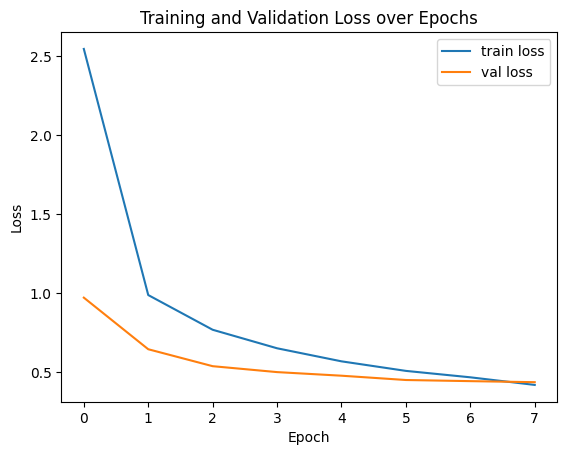

In [120]:
plt.figure()
plt.plot(tl, label='train loss')
plt.plot(vl, label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()

## Saving the model checkpoint

Define paths

In [26]:
models_dir = '/srv/newpenny/XAI/models'

Add your initials to model name, e.g.:
```python
my_initials = 'LM'
model_path = f'{my_initials}_etc.pth'

In [27]:
my_initials = 'SV' # use yours!
model_name =  model_name # should be already defined
dataset_name = dataset # should be already defined
other_params = 'augment=True_optim=SGD_scheduler=LROnPlateau' # 'make_string_of_other_relevant_params' # can be optimizer, epochs, final lr...

path = f'{my_initials}_model={model_name}_dataset={dataset_name}_{other_params}.pth'
model_path = os.path.join(models_dir, path)

In [28]:
model_path

'/srv/newpenny/XAI/models/SV_model=vit_b_16_dataset=CIFAR100_augment=True_optim=SGD_scheduler=LROnPlateau.pth'

In [26]:
model_path = '/srv/newpenny/XAI/models/SV_model=vit_b_16_dataset=CIFAR100_augment=True_optim=SGD_scheduler=LROnPlateau_withInfo.pth'
model_path

'/srv/newpenny/XAI/models/SV_model=vit_b_16_dataset=CIFAR100_augment=True_optim=SGD_scheduler=LROnPlateau_withInfo.pth'

### Save the basic version: `model.state_dict()` only

Remember that `model.state_dict()` will contain all parameters learned after training

In [ ]:
#model_path = '/srv/newpenny/XAI/models/SV_model=vit_b_16_dataset=CIFAR100_augment=True_optim=SGD_scheduler=LROnPlateau_basic.pth'

In [ ]:
# decomment to save
# torch.save(model.state_dict(), model_path)

You can then load the learned parameters

In [ ]:
# model = Net() # instantiate the kind of model -> Net() is a placeholder
# model.load_state_dict(torch.load(model_path, weights_only=True)) # load saved parameters (weights and biases)

We name the model `model_basic` instead of `model` because I don't want to override the variable.

In [ ]:
model_basic = torchvision.models.vit_b_16()

In [ ]:
# change the number of classes from 1000 to 100
in_features = model.heads.head.in_features

model_basic.heads.head = torch.nn.Linear(in_features, n_classes)

In [73]:
model_path_basic = '/srv/newpenny/XAI/models/SV_model=vit_b_16_dataset=CIFAR100_augment=True_optim=SGD_scheduler=LROnPlateau_basic.pth'

In [ ]:
state_dict = torch.load(model_path_basic, weights_only=True, map_location='cpu')
model_basic.load_state_dict(state_dict) # load saved parameters (weights and biases)

### Save the checkpoint with info

In [ ]:
#save in the checkpoint variable all the useful info of the model
checkpoint = {
    'state_dict' : model.state_dict(),
    'epoch': num_epochs,
    'initial_lr' : initial_lr,
    'final_lr': current_lr,
    'train_accuracy': train_accuracy,
    'val_accuracy': val_accuracy
}

Eventually add a loss plot for quick visualization of the training process

In [ ]:
plt.figure()
plt.plot(tl, label='train loss')
plt.plot(vl, label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()

buf = io.BytesIO()
plt.savefig(buf, format='PNG')
buf.seek(0)
checkpoint['loss_plot'] = buf.getvalue() 
plt.close()

In [ ]:
# decomment to save
torch.save(checkpoint, model_path)

#### Load the model with info from .pth file

You can then load the learned parameters

In [19]:
model_path = '/srv/newpenny/XAI/models/SV_model=vit_b_16_dataset=CIFAR100_augment=True_optim=SGD_scheduler=LROnPlateau_withInfo.pth'
model_path

'/srv/newpenny/XAI/models/SV_model=vit_b_16_dataset=CIFAR100_augment=True_optim=SGD_scheduler=LROnPlateau_withInfo.pth'

In [20]:
# model = Net() # decomment and instantiate the kind of model you want
checkpoint = torch.load(model_path,  weights_only=False, map_location='cpu')
model.load_state_dict(checkpoint['state_dict']) # load saved parameters (weights and biases)

<All keys matched successfully>

If you saved a loss plot as suggested above:

In [21]:
# access the image bytes and display it
image_bytes = checkpoint['loss_plot']
image = Image.open(io.BytesIO(image_bytes))
#image.show()  # this will open the image in the default image viewer

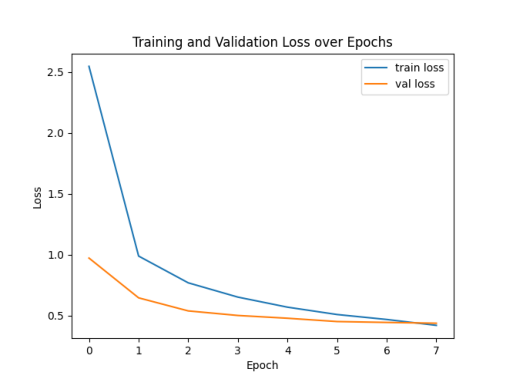

In [22]:
# alternatively, display the image inline (if in a notebook or interactive environment)
plt.imshow(image)
plt.axis('off')
plt.show()

random tries

In [135]:
model_load_withInfo = torchvision.models.vit_b_16()

# change the number of classes from 1000 to 100
in_features = model.heads.head.in_features
model_load_withInfo.heads.head = torch.nn.Linear(in_features, n_classes)

checkpoint = torch.load(model_path)
model_load_withInfo.load_state_dict(checkpoint['state_dict']) # load saved parameters (weights and biases)

/tmp/ipykernel_604027/1629861010.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


<All keys matched successfully>

In [ ]:
image_bytes = checkpoint['loss_plot']
image = Image.open(io.BytesIO(image_bytes))
image.show()  # this will open the image in the default image viewer

Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)


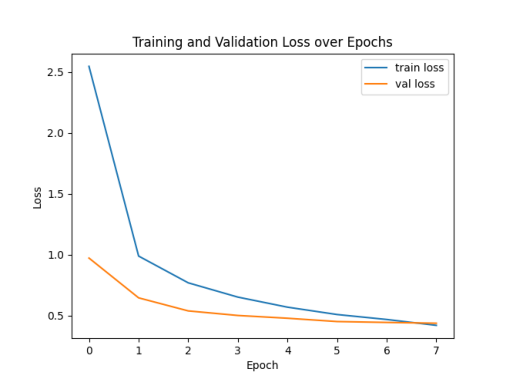

In [39]:
# alternatively, display the image inline (if in a notebook or interactive environment)
plt.imshow(image)
plt.axis('off')
plt.show()

# TODO!
* Approximate the parameters of each available layer with SVD and show the singular value (SV) profiles
* Compute the ratio between the largest SV and smaller SVs for each layer
* You can use the resources from our github repo to do so &#128522;

In [145]:
#model_load_withInfo.state_dict().keys()
#model_load_withInfo

#### Take the weights and biases from one single layer and compute the SVD

In [144]:
model_load_withInfo.state_dict().keys()

odict_keys(['class_token', 'conv_proj.weight', 'conv_proj.bias', 'encoder.pos_embedding', 'encoder.layers.encoder_layer_0.ln_1.weight', 'encoder.layers.encoder_layer_0.ln_1.bias', 'encoder.layers.encoder_layer_0.self_attention.in_proj_weight', 'encoder.layers.encoder_layer_0.self_attention.in_proj_bias', 'encoder.layers.encoder_layer_0.self_attention.out_proj.weight', 'encoder.layers.encoder_layer_0.self_attention.out_proj.bias', 'encoder.layers.encoder_layer_0.ln_2.weight', 'encoder.layers.encoder_layer_0.ln_2.bias', 'encoder.layers.encoder_layer_0.mlp.0.weight', 'encoder.layers.encoder_layer_0.mlp.0.bias', 'encoder.layers.encoder_layer_0.mlp.3.weight', 'encoder.layers.encoder_layer_0.mlp.3.bias', 'encoder.layers.encoder_layer_1.ln_1.weight', 'encoder.layers.encoder_layer_1.ln_1.bias', 'encoder.layers.encoder_layer_1.self_attention.in_proj_weight', 'encoder.layers.encoder_layer_1.self_attention.in_proj_bias', 'encoder.layers.encoder_layer_1.self_attention.out_proj.weight', 'encoder.la

E.g. I take a layer weights and biases:

- `'encoder.layers.encoder_layer_0.ln_2.weight'`
- `'encoder.layers.encoder_layer_0.ln_2.bias'`

Apparently not these specifically since these are normalization layers

In [ ]:
layer_name_weight = 'heads.head.weight'	#take the head of the net
layer_name_bias = 'heads.head.bias'

layer_weights = model_load_withInfo.state_dict()[layer_name_weight]
layer_bias = model_load_withInfo.state_dict()[layer_name_bias]

#print(f"Weights dim of {layer_name_weight}: {layer_weights.shape}")
#print(f"Biases dim of {layer_name_bias}: {layer_bias.shape}")

In [218]:
print(layer_weights.shape)
print(layer_bias.shape)
print(type(layer_weights))

torch.Size([100, 768])
torch.Size([100])
<class 'torch.Tensor'>


In [ ]:
# reshape the bias tensor
layer_bias = layer_bias.reshape(-1, 1)
print(layer_bias.shape)

torch.Size([100, 1])


Now we concat the weights matrix and the bias array in a new matrix `A`

In [220]:
A = torch.cat((layer_weights, layer_bias), dim=1)

Compute SVD.

In [221]:
U, s, V = torch.linalg.svd(A)
print(U.shape)
print(s.shape)
print(V.shape)

torch.Size([100, 100])
torch.Size([100])
torch.Size([769, 769])


Optional part: check if the approx of `s` is ok

The `torch.linalg.svd` return an array with the singular values, we need to build the augmented matrix and add the correct number of "zero rows".

In [222]:
# diag matrix
S = torch.diag(s)
print(S.shape)

# zeros matrix
S_zeros =torch.zeros(100,669)

# concat the 2 mat
S = torch.cat((S, S_zeros), dim=1)
print(S.shape)

torch.Size([100, 100])
torch.Size([100, 769])


In [ ]:
# check with the norm if this is a good approx
torch.linalg.norm(A - (U @ S @ V))

tensor(8.9844e-06)

We try to plot the profiles of the singular values of `s`

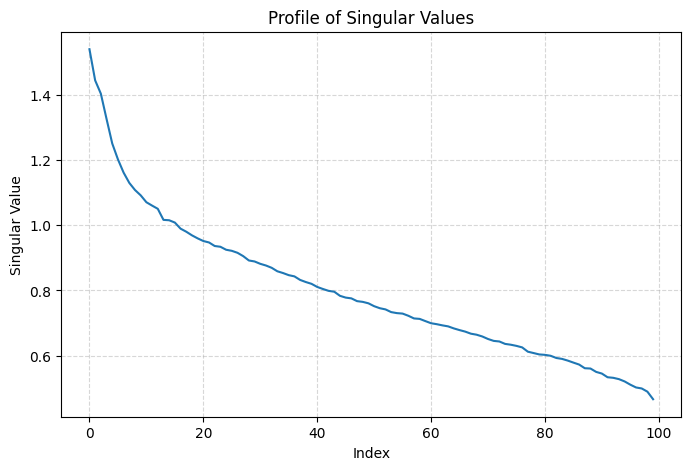

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(s.numpy())
plt.title('Profile of Singular Values')
plt.xlabel('Index')
plt.ylabel('Singular Value')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

##### Use svd_lowrank to compute svd

In [199]:
U_low, s_low, V_low = torch.svd_lowrank(A, q=769)

In [203]:
S_low = torch.diag(s_low)
print(S_low.shape)
S_zeros = torch.zeros(100,669)
S_low = torch.cat((S_low, S_zeros), dim=1)
print(S_low.shape)

torch.Size([100, 100])
torch.Size([100, 769])


In [200]:
print(U_low.shape)
print(s_low.shape)
print(V_low.shape)

torch.Size([100, 100])
torch.Size([100])
torch.Size([769, 100])


In [207]:
(U_low@S_low@V_low).shape

torch.Size([100, 100])

In [206]:
torch.linalg.norm(A-(U_low@S_low@V_low))

RuntimeError: The size of tensor a (769) must match the size of tensor b (100) at non-singleton dimension 1

In [208]:
A.shape

torch.Size([100, 769])

##### Do it for all the layers in the ViT

Do a for loop where we cycle through the `state dict` and we check for the shape of each layer, if it's a vector (e.g. [100]) we discard it, otherwise if it's a matrix we take it and save the corresponding biases. Then we proceed to to what we showed before in the previous section.

In [231]:
type(model_load_withInfo.state_dict())

collections.OrderedDict